# Sheldon Production Evaluation Analysis
## Focus: CA and CA+HC roles only

**Analysis scope:**
- Filter for CA (Customer Advocate) and CA+HC roles
- Exclude RD-only data
- Analyze Q&A quality for production evaluation

## Setup & Imports

In [13]:
# Import all required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from pymongo import MongoClient
from bson.objectid import ObjectId
import os
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported")

✅ All libraries imported


In [14]:
# Load environment variables and setup connections
load_dotenv()

# MySQL connection
DATABASE_URL = os.getenv('MYSQL_DATABASE_URL')
if DATABASE_URL:
    DATABASE_URL = DATABASE_URL.replace('mysql+aiomysql://', 'mysql+pymysql://')
mysql_engine = create_engine(DATABASE_URL, echo=False, pool_pre_ping=True)

# MongoDB connection
MONGO_URI = os.getenv('MONGO_DATABASE_URI')
mongo_client = MongoClient(MONGO_URI)
mongo_db = mongo_client['UnifiedCare']
employees_collection = mongo_db['employees']
role_assignments_collection = mongo_db['role_assignments']

print("✅ MySQL connected")
print("✅ MongoDB connected")
print(f"   MongoDB Database: {mongo_db.name}")
print(f"   Collections: employees, role_assignments")

✅ MySQL connected
✅ MongoDB connected
   MongoDB Database: UnifiedCare
   Collections: employees, role_assignments


## Step 1: Get User Details and Filter for CA/CA+HC Roles

In [15]:
# Function to get user details from MongoDB
def get_user_details(user_id_str):
    """Get user details from MongoDB employees and role_assignments collections"""
    try:
        user_obj_id = ObjectId(user_id_str)
        
        # Get user info from employees collection
        user_doc = employees_collection.find_one({"_id": user_obj_id})
        
        # Get roles from role_assignments collection
        role_docs = list(role_assignments_collection.find({"memberId": user_obj_id}))
        unique_roles = list(set([doc.get('roleType') for doc in role_docs if doc.get('roleType')]))
        roles_str = ', '.join(sorted(unique_roles)) if unique_roles else 'N/A'
        
        if user_doc:
            return {
                'user_id': user_id_str,
                'name': user_doc.get('name', {}).get('full', 'N/A'),
                'email': user_doc.get('email', 'N/A'),
                'roles': roles_str,
                'status': user_doc.get('status', 'N/A')
            }
        else:
            return {
                'user_id': user_id_str,
                'name': 'Not Found',
                'email': 'N/A',
                'roles': roles_str if unique_roles else 'N/A',
                'status': 'N/A'
            }
    except Exception as e:
        return {
            'user_id': user_id_str,
            'name': f'Error: {str(e)}',
            'email': 'N/A',
            'roles': 'N/A',
            'status': 'N/A'
        }

print("✅ User details function ready")

✅ User details function ready


In [16]:
# Get all unique user_ids from Sheldon usage
query_users = text("""
    SELECT DISTINCT user_id
    FROM ai.chat_history
    WHERE action_type = 'Sheldon'
        AND timestamp >= '2024-01-01'
    ORDER BY user_id
""")

with mysql_engine.connect() as conn:
    user_ids_df = pd.read_sql(query_users, conn)

print(f"📊 Found {len(user_ids_df)} unique Sheldon users")

# Fetch all user details from MongoDB
print("🔄 Fetching user details from MongoDB...\n")

user_details_list = []
for idx, row in user_ids_df.iterrows():
    user_id = row['user_id']
    user_info = get_user_details(user_id)
    user_details_list.append(user_info)
    
    if (idx + 1) % 20 == 0:
        print(f"   Processed {idx + 1}/{len(user_ids_df)} users...")

users_info_df = pd.DataFrame(user_details_list)
print(f"\n✅ Retrieved information for {len(users_info_df)} users")

📊 Found 114 unique Sheldon users
🔄 Fetching user details from MongoDB...

   Processed 20/114 users...
   Processed 40/114 users...
   Processed 60/114 users...
   Processed 80/114 users...
   Processed 100/114 users...

✅ Retrieved information for 114 users


In [17]:
# Filter for CA and CA+HC roles only (exclude RD-only)
def is_ca_or_ca_hc(roles_str):
    """Check if role is CA or CA+HC (not RD-only)"""
    if pd.isna(roles_str) or roles_str == 'N/A':
        return False
    
    roles_list = [r.strip() for r in roles_str.split(',')]
    
    # Check if CA is in the roles
    if 'CA' in roles_list:
        return True
    
    return False

# Apply filter
users_info_df['is_ca_target'] = users_info_df['roles'].apply(is_ca_or_ca_hc)
ca_users_df = users_info_df[users_info_df['is_ca_target']].copy()

print("=" * 70)
print("📋 USER ROLE FILTERING")
print("=" * 70)
print(f"\nTotal Sheldon users: {len(users_info_df)}")
print(f"CA/CA+HC users: {len(ca_users_df)}")
print(f"Excluded (RD-only and others): {len(users_info_df) - len(ca_users_df)}")

print(f"\n📊 Role distribution for selected users:")
role_counts = ca_users_df['roles'].value_counts()
display(role_counts.head(10))

# Get list of CA user IDs
ca_user_ids = ca_users_df['user_id'].tolist()
print(f"\n✅ {len(ca_user_ids)} CA/CA+HC user IDs ready for filtering")

📋 USER ROLE FILTERING

Total Sheldon users: 114
CA/CA+HC users: 52
Excluded (RD-only and others): 62

📊 Role distribution for selected users:


roles
CA                            29
CA, HC                         6
ADMIN, CA, HC                  5
ADMIN, CA, HC, RD              3
CA, RD                         3
ADMIN, CA, MANAGER             1
ADMIN, CA, HC, MANAGER, RD     1
CA, MANAGER                    1
ADMIN, BILLER, CA, HC, RD      1
ADMIN, CA                      1
Name: count, dtype: int64


✅ 52 CA/CA+HC user IDs ready for filtering


## Step 2: Query CA/CA+HC Chat Records

In [18]:
# Query all Sheldon records including retrieval_results
query_all_records = text("""
    SELECT 
        ch.id,
        ch.user_id,
        ch.session_id,
        ch.patient_id,
        ch.timestamp,
        ch.question,
        ch.answer,
        ch.retrieval_results,
        ch.action_type,
        ch.total_tokens,
        ch.llm_process_time
    FROM ai.chat_history ch
    WHERE ch.action_type = 'Sheldon'
        AND ch.timestamp >= '2024-01-01'
    ORDER BY ch.timestamp DESC
""")

print("🔄 Querying all Sheldon records...")

with mysql_engine.connect() as conn:
    all_records_df = pd.read_sql(query_all_records, conn)

print(f"✅ Total Sheldon records retrieved: {len(all_records_df):,}")

# Filter for CA users only
ca_records_df = all_records_df[all_records_df['user_id'].isin(ca_user_ids)].copy()

print(f"✅ CA/CA+HC records after filtering: {len(ca_records_df):,}")
print(f"   Records excluded (RD-only, etc.): {len(all_records_df) - len(ca_records_df):,}")

🔄 Querying all Sheldon records...
✅ Total Sheldon records retrieved: 1,728
✅ CA/CA+HC records after filtering: 752
   Records excluded (RD-only, etc.): 976


## Step 3: Analyze Answer Completeness

In [19]:
# Analyze answer and retrieval_results completeness
ca_records_df['answer_is_empty'] = ca_records_df['answer'].isna() | (ca_records_df['answer'].str.strip() == '')
ca_records_df['retrieval_is_empty'] = ca_records_df['retrieval_results'].isna() | (ca_records_df['retrieval_results'].str.strip() == '')

empty_answer_df = ca_records_df[ca_records_df['answer_is_empty']].copy()
empty_retrieval_df = ca_records_df[ca_records_df['retrieval_is_empty']].copy()
has_answer_df = ca_records_df[~ca_records_df['answer_is_empty']].copy()

print("=" * 70)
print("📊 CA/CA+HC RECORDS ANALYSIS")
print("=" * 70)
print(f"\n✅ Total CA/CA+HC records: {len(ca_records_df):,}")
print(f"   - Records with answer: {len(has_answer_df):,} ({len(has_answer_df)/len(ca_records_df)*100:.1f}%)")
print(f"   - Records with null/empty answer: {len(empty_answer_df):,} ({len(empty_answer_df)/len(ca_records_df)*100:.1f}%)")
print(f"   - Records with null/empty retrieval_results: {len(empty_retrieval_df):,} ({len(empty_retrieval_df)/len(ca_records_df)*100:.1f}%)")

if len(empty_answer_df) > 0:
    print(f"\n❌ Sample questions with null/empty answers:")
    display(empty_answer_df[['id', 'user_id', 'timestamp', 'question', 'answer']].head(20))
else:
    print(f"\n✅ All CA/CA+HC records have answers!")

if len(empty_retrieval_df) > 0:
    print(f"\n❌ Sample questions with null/empty retrieval_results:")
    display(empty_retrieval_df[['id', 'user_id', 'timestamp', 'question', 'retrieval_results']].head(20))
else:
    print(f"\n✅ All CA/CA+HC records have retrieval_results!")

print(f"\n✅ Records available for evaluation: {len(has_answer_df):,}")
print(f"\n📋 Sample questions with answers:")
display(has_answer_df[['id', 'user_id', 'timestamp', 'question', 'answer', 'retrieval_results']].head(10))

📊 CA/CA+HC RECORDS ANALYSIS

✅ Total CA/CA+HC records: 752
   - Records with answer: 692 (92.0%)
   - Records with null/empty answer: 60 (8.0%)
   - Records with null/empty retrieval_results: 58 (7.7%)

❌ Sample questions with null/empty answers:


,id,user_id,timestamp,question,answer
8,62033,5f761c3889ae140013db6cdf,2025-11-10 05:00:11,Where is the intake form?,None
26,60208,6564f6d5f7a6bd00139fb3ff,2025-11-03 17:38:51,weight scale features,None
36,58954,68700e24ec46de7e7f67119d,2025-10-28 14:06:13,How to use the control solution for the BG mon...,None
44,57588,65836095d2eb5b0013261dd8,2025-10-21 21:47:40,BP alert,None
45,57587,65836095d2eb5b0013261dd8,2025-10-21 21:47:18,do you know about the BP reminders?,None
51,56587,68700e24ec46de7e7f67119d,2025-10-16 20:01:23,hướng dẫn cach đo huyết áp,None
61,55627,66c4d683b47a204fb3250a27,2025-10-13 14:33:51,Is it normal for a different blood glucose dev...,None
68,53671,68700e24ec46de7e7f67119d,2025-10-06 13:43:29,DO we have facial yoga?,None
69,53670,68700e24ec46de7e7f67119d,2025-10-06 13:43:07,Do we have facial yoga?,None
89,52980,68700e24ec46de7e7f67119d,2025-10-02 13:26:19,How,None



❌ Sample questions with null/empty retrieval_results:


,id,user_id,timestamp,question,retrieval_results
8,62033,5f761c3889ae140013db6cdf,2025-11-10 05:00:11,Where is the intake form?,None
26,60208,6564f6d5f7a6bd00139fb3ff,2025-11-03 17:38:51,weight scale features,None
36,58954,68700e24ec46de7e7f67119d,2025-10-28 14:06:13,How to use the control solution for the BG mon...,None
44,57588,65836095d2eb5b0013261dd8,2025-10-21 21:47:40,BP alert,None
45,57587,65836095d2eb5b0013261dd8,2025-10-21 21:47:18,do you know about the BP reminders?,None
51,56587,68700e24ec46de7e7f67119d,2025-10-16 20:01:23,hướng dẫn cach đo huyết áp,None
61,55627,66c4d683b47a204fb3250a27,2025-10-13 14:33:51,Is it normal for a different blood glucose dev...,None
68,53671,68700e24ec46de7e7f67119d,2025-10-06 13:43:29,DO we have facial yoga?,None
69,53670,68700e24ec46de7e7f67119d,2025-10-06 13:43:07,Do we have facial yoga?,None
89,52980,68700e24ec46de7e7f67119d,2025-10-02 13:26:19,How,None



✅ Records available for evaluation: 692

📋 Sample questions with answers:


,id,user_id,timestamp,question,answer,retrieval_results
0,62148,6442f335da98140013e79425,2025-11-10 18:34:02,clinic 93,"{""answer"":""Clinic 93 offers in-house A1c testi...","{""retrievalResults"":[{""content"":{""text"":""Clini..."
1,62147,6442f335da98140013e79425,2025-11-10 18:33:44,clinic 87,"{""answer"":""Clinic 87 has in-house A1c testing ...","{""retrievalResults"":[{""content"":{""text"":""Clini..."
2,62146,6442f335da98140013e79425,2025-11-10 18:33:31,clinic 3,"{""answer"":""Clinic 3 may also offer in-house A1...","{""retrievalResults"":[{""content"":{""text"":""Clini..."
3,62145,6442f335da98140013e79425,2025-11-10 18:33:17,clinic 2,"{""answer"":""Clinic 2 also provides in-house A1c...","{""retrievalResults"":[{""content"":{""text"":""Clini..."
4,62144,6442f335da98140013e79425,2025-11-10 18:32:57,how about other clinic,"{""answer"":""Other clinics may have varying capa...","{""retrievalResults"":[{""content"":{""text"":""Ensur..."
5,62143,6442f335da98140013e79425,2025-11-10 18:32:46,which clinic has in house a1c,Clinic 1 has in-house A1c testing available at...,"{""retrievalResults"":[{""content"":{""text"":"". ..."
6,62142,6442f335da98140013e79425,2025-11-10 18:32:11,does clinic 1 has in house a1c,Clinic 1 patients must schedule their A1c test...,"{""retrievalResults"":[{""content"":{""text"":"". ..."
7,62141,6442f335da98140013e79425,2025-11-10 18:31:45,what is clinic 1 CA,Clinic 1 refers to a specific clinic location ...,"{""retrievalResults"":[{""content"":{""text"":"". ..."
9,62015,6667697ea288866831d1b81d,2025-11-08 04:28:55,Can you pull me the related issue about heart ...,Certainly! Here’s some information related to ...,"{""retrievalResults"":[{""content"":{""text"":""Copyr..."
15,60644,68700e24ec46de7e7f67119d,2025-11-04 22:11:47,show me where ccan I accesse to the video tuto...,You can find the video tutorial in the app by ...,"{""retrievalResults"":[{""content"":{""text"":""Ask t..."


## Step 4: Statistics for Records with Answers

In [20]:
# Merge with user info for detailed analysis
has_answer_with_user = has_answer_df.merge(
    ca_users_df[['user_id', 'name', 'email', 'roles', 'status']], 
    on='user_id', 
    how='left'
)

print("=" * 70)
print("📈 CA/CA+HC RECORDS WITH ANSWERS - STATISTICS")
print("=" * 70)

print(f"\n📅 Date Range:")
print(f"   First record: {has_answer_df['timestamp'].min()}")
print(f"   Last record: {has_answer_df['timestamp'].max()}")

print(f"\n👥 Unique CA/CA+HC Users with answers: {has_answer_df['user_id'].nunique()}")
print(f"📝 Unique sessions with answers: {has_answer_df['session_id'].nunique()}")
print(f"🏥 Unique patients: {has_answer_df['patient_id'].nunique()}")

print(f"\n💬 Token Statistics (records with answers):")
print(f"   Average tokens per interaction: {has_answer_df['total_tokens'].mean():,.0f}")
print(f"   Median tokens: {has_answer_df['total_tokens'].median():,.0f}")
print(f"   Total tokens: {has_answer_df['total_tokens'].sum():,.0f}")

print(f"\n⏱️ Processing Time Statistics (records with answers):")
print(f"   Average process time: {has_answer_df['llm_process_time'].mean():.2f}s")
print(f"   Median process time: {has_answer_df['llm_process_time'].median():.2f}s")

# Question length analysis
has_answer_df['question_length'] = has_answer_df['question'].str.len()
has_answer_df['answer_length'] = has_answer_df['answer'].str.len()

print(f"\n📏 Text Length Statistics:")
print(f"   Average question length: {has_answer_df['question_length'].mean():,.0f} characters")
print(f"   Average answer length: {has_answer_df['answer_length'].mean():,.0f} characters")

print("\n" + "=" * 70)

📈 CA/CA+HC RECORDS WITH ANSWERS - STATISTICS

📅 Date Range:
   First record: 2024-09-06 16:10:12
   Last record: 2025-11-10 18:34:02

👥 Unique CA/CA+HC Users with answers: 52
📝 Unique sessions with answers: 401
🏥 Unique patients: 0

💬 Token Statistics (records with answers):
   Average tokens per interaction: 2,316
   Median tokens: 1,832
   Total tokens: 1,602,676

⏱️ Processing Time Statistics (records with answers):
   Average process time: nans
   Median process time: nans

📏 Text Length Statistics:
   Average question length: 58 characters
   Average answer length: 1,996 characters



In [21]:
# Usage by specific role (CA vs CA+HC)
print("📋 Usage by Role Type:\n")
role_summary = has_answer_with_user.groupby('roles').agg({
    'id': 'count',
    'user_id': 'nunique',
    'session_id': 'nunique',
    'total_tokens': 'sum'
}).rename(columns={
    'id': 'total_records',
    'user_id': 'unique_users',
    'session_id': 'unique_sessions'
}).sort_values('total_records', ascending=False)

display(role_summary)

📋 Usage by Role Type:



,total_records,unique_users,unique_sessions,total_tokens
roles,,,,
CA,534,29,309,1226492.0
"CA, HC",62,6,37,157456.0
"CA, RD",28,3,18,49592.0
"ADMIN, CA, HC, RD",26,3,9,68867.0
"ADMIN, CA, HC",15,5,9,31310.0
"CA, MANAGER",9,1,6,32755.0
"ADMIN, CA, RD",6,1,3,13378.0
"ADMIN, CA, HC, MANAGER, RD",4,1,3,6589.0
"ADMIN, BILLER, CA, HC, RD",3,1,2,6991.0


## Step 5: Monthly Trend Analysis

📈 Monthly CA/CA+HC Usage Trend:



,total_interactions,unique_users,unique_sessions,sum_tokens
month,,,,
2024-09,115,27,66,285406.0
2024-10,98,22,62,268722.0
2024-11,67,12,34,246808.0
2024-12,47,13,31,124361.0
2025-01,58,15,43,140987.0
2025-02,25,10,16,46831.0
2025-03,49,13,28,82404.0
2025-04,46,9,22,80283.0
2025-05,38,9,20,63547.0


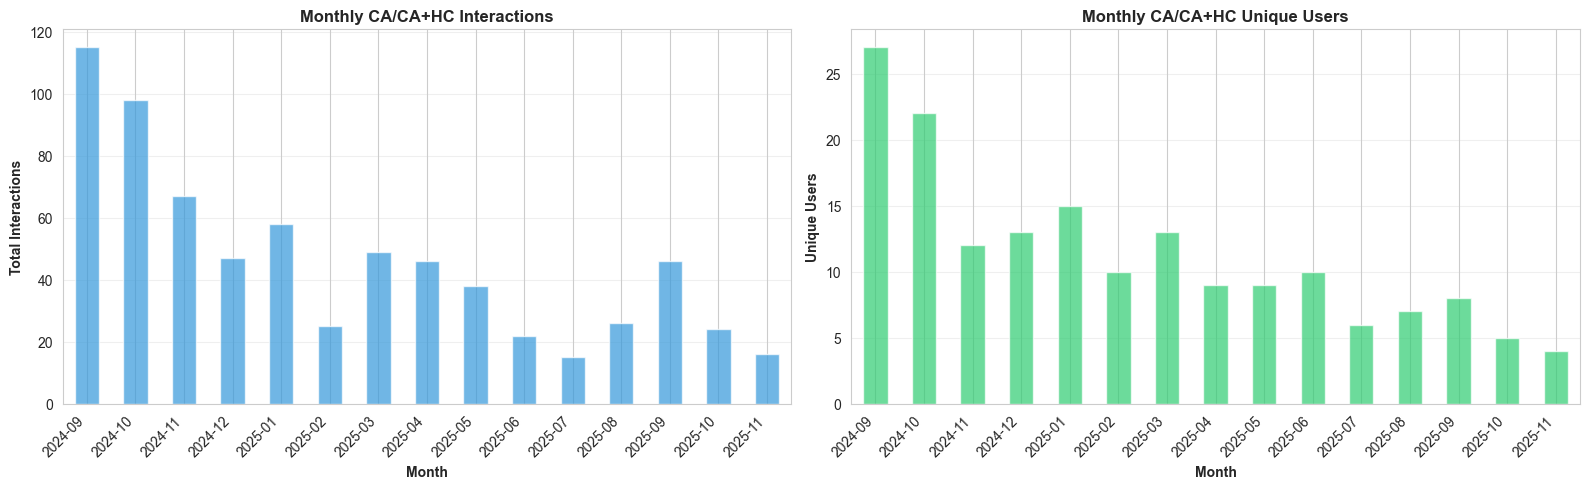

In [22]:
# Add month column for trend analysis
has_answer_df['month'] = pd.to_datetime(has_answer_df['timestamp']).dt.to_period('M')

monthly_stats = has_answer_df.groupby('month').agg({
    'id': 'count',
    'user_id': 'nunique',
    'session_id': 'nunique',
    'total_tokens': 'sum'
}).rename(columns={
    'id': 'total_interactions',
    'user_id': 'unique_users',
    'session_id': 'unique_sessions',
    'total_tokens': 'sum_tokens'
})

print("📈 Monthly CA/CA+HC Usage Trend:\n")
display(monthly_stats)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Monthly interactions
monthly_stats['total_interactions'].plot(kind='bar', ax=ax1, color='#3498db', alpha=0.7)
ax1.set_title('Monthly CA/CA+HC Interactions', fontweight='bold', fontsize=12)
ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Total Interactions', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Monthly unique users
monthly_stats['unique_users'].plot(kind='bar', ax=ax2, color='#2ecc71', alpha=0.7)
ax2.set_title('Monthly CA/CA+HC Unique Users', fontweight='bold', fontsize=12)
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Unique Users', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Step 6: Export Data for Evaluation

In [23]:
# Export CA/CA+HC records with answers for evaluation
output_ca_eval = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_eval_prod.csv'
has_answer_with_user.to_csv(output_ca_eval, index=False)
print(f"✅ CA/CA+HC evaluation data exported to: {output_ca_eval}")

# Export all CA/CA+HC records (including empty answers)
ca_records_with_user = ca_records_df.merge(
    ca_users_df[['user_id', 'name', 'email', 'roles', 'status']], 
    on='user_id', 
    how='left'
)
output_ca_all = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_all_prod.csv'
ca_records_with_user.to_csv(output_ca_all, index=False)
print(f"✅ All CA/CA+HC records exported to: {output_ca_all}")

if len(empty_answer_df) > 0:
    output_ca_empty = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_empty_answers_prod.csv'
    empty_answer_df.to_csv(output_ca_empty, index=False)
    print(f"✅ CA/CA+HC records with empty answers exported to: {output_ca_empty}")

# Export user list
output_users = '/Users/sagegu/Documents/ai_data_analysis/sheldon_ca_users_prod.csv'
ca_users_df.to_csv(output_users, index=False)
print(f"✅ CA/CA+HC user list exported to: {output_users}")

print(f"\n" + "=" * 70)
print("📊 EVALUATION DATASET READY")
print("=" * 70)
print(f"\n✅ CA/CA+HC records with complete Q&A pairs: {len(has_answer_df):,}")
print(f"✅ Unique CA/CA+HC users: {len(ca_users_df):,}")
print(f"✅ Date range: {has_answer_df['timestamp'].min()} to {has_answer_df['timestamp'].max()}")
print(f"\n📁 Files exported:")
print(f"   - {output_ca_eval}")
print(f"   - {output_ca_all}")
print(f"   - {output_users}")
if len(empty_answer_df) > 0:
    print(f"   - {output_ca_empty}")
print(f"\n🎯 Ready for production evaluation!")

✅ CA/CA+HC evaluation data exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_eval_prod.csv
✅ All CA/CA+HC records exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_all_prod.csv
✅ CA/CA+HC records with empty answers exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_empty_answers_prod.csv
✅ CA/CA+HC user list exported to: /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_users_prod.csv

📊 EVALUATION DATASET READY

✅ CA/CA+HC records with complete Q&A pairs: 692
✅ Unique CA/CA+HC users: 52
✅ Date range: 2024-09-06 16:10:12 to 2025-11-10 18:34:02

📁 Files exported:
   - /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_eval_prod.csv
   - /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_all_prod.csv
   - /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_users_prod.csv
   - /Users/sagegu/Documents/ai_data_analysis/sheldon_ca_empty_answers_prod.csv

🎯 Ready for production evaluation!


## Cleanup

In [24]:
# Close all connections
mysql_engine.dispose()
mongo_client.close()

print("✅ MySQL connection closed")
print("✅ MongoDB connection closed")
print("\n" + "=" * 70)
print("🎉 ANALYSIS COMPLETE!")
print("=" * 70)

✅ MySQL connection closed
✅ MongoDB connection closed

🎉 ANALYSIS COMPLETE!
